# Moon Cycles: Turning Points (Step 2 Astro Model)

Goal of this notebook:
- Reuse Step 1 turning-point logic with your selected parameters.
- Build full astro feature matrix (including transit-to-natal with explicit birth datetime).
- Train binary direction model: `DOWN (0)` vs `UP (1)`.
- Handle sparse turning events with denser target representations.
- Show clearly what the model labeled on test (true vs predicted), then run a simple trading sanity check.

Target modes implemented:
- `point_only`: only exact turn dates are labeled.
- `window_kernel`: label nearby dates with distance-decay weights.
- `segment_midpoint`: label point-to-point ranges with maximum weight near range center.


In [1]:
from __future__ import annotations

# Standard library imports.
from dataclasses import asdict
from pathlib import Path
import sys

# Core scientific stack.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn helper to compensate class imbalance.
from sklearn.utils.class_weight import compute_sample_weight

# Project root bootstrap so local imports work in notebook execution.
PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project config and model wrapper.
from RESEARCH.config import cfg as project_cfg
from RESEARCH.data_loader import get_latest_date
from RESEARCH.model_training import check_cuda_available
from src.models.xgb import XGBBaseline

# Moon-cycle / turning-point research modules.
from RESEARCH2.Moon_cycles.moon_data import load_market_slice
from RESEARCH2.Moon_cycles.splits import make_classic_split, describe_split
from RESEARCH2.Moon_cycles.eval_utils import compute_binary_metrics, compute_statistical_significance
from RESEARCH2.Moon_cycles.eval_visuals import VisualizationConfig
from RESEARCH2.Moon_cycles.threshold_utils import tune_threshold_with_balance, evaluate_threshold_grid
from RESEARCH2.Moon_cycles.turning_points import (
    TurningPointLabelConfig,
    label_turning_points,
    plot_turning_points_chart,
)
from RESEARCH2.Moon_cycles.turning_astro_features import (
    TurningAstroFeatureConfig,
    build_turning_astro_feature_set,
    summarize_feature_groups,
)
from RESEARCH2.Moon_cycles.turning_targets import (
    build_turning_target_frame,
    merge_features_with_turning_target,
)
from RESEARCH2.Moon_cycles.turning_targets_numba import NUMBA_AVAILABLE
from RESEARCH2.Moon_cycles.trading_utils import (
    TradingConfig,
    build_signal_from_proba,
    backtest_long_flat_signals,
    plot_backtest_price_and_equity,
)
from RESEARCH2.Moon_cycles.trading_utils_short import backtest_long_short_signals
from production_dev.coingecko_client import fetch_current_btc_price_usd

pd.set_option('display.max_columns', 240)
pd.set_option('display.width', 220)

# Higher-resolution charts for notebook rendering.
PLOT_DPI = 180
plt.rcParams['figure.dpi'] = PLOT_DPI
plt.rcParams['savefig.dpi'] = PLOT_DPI
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('retina')
except Exception:
    pass


In [2]:
# ============================================================================
# Configuration (explicit and reproducible)
# ============================================================================
# Why so many constants?
# - Research notebooks are easiest to debug when every assumption is visible.
# - We can re-run later and know exactly which setup produced the result.

# 1) Data range (raw history before local window slicing).
START_DATE = '2017-11-01'
END_DATE = None

# 2) Window mode.
#    User request: use the full available period so test plot is truly full test.
DATA_WINDOW_MODE = 'full'   # full | last_n_days | range_pct
DATA_LAST_N_DAYS = 360
DATA_RANGE_PCT = (70, 100)
INCLUDE_TODAY_LIVE_ROW = True  # If today's candle is absent, append live BTC price as provisional close.
LIVE_TODAY_TIMEOUT = 10
FORCE_TODAY_DATE = None  # Optional YYYY-MM-DD override for manual backfill tests.

# 3) Turning-point detector parameters you selected.
#    Important: this config already uses BOTH future and past confirmations.
TAIL_DIRECTION_MODE = 'endpoint_sign'  # last_turn | endpoint_sign
TAIL_MIN_MOVE_PCT = 0.0
TURN_CFG = TurningPointLabelConfig(
    horizon_days=10,
    up_move_pct=0.037,
    down_move_pct=0.037,
    cluster_gap_days=5,
    min_turn_gap_days=8,
    past_horizon_days=13,
    past_up_move_pct=0.090,
    past_down_move_pct=0.090,
    tail_direction_mode=TAIL_DIRECTION_MODE,
    tail_min_move_pct=TAIL_MIN_MOVE_PCT,
)

# 4) Birth datetime must always be logged (transit-to-natal depends on it).
BIRTH_DT_UTC = str(project_cfg.subject.get('birth_dt_utc', '2009-10-10T18:15:05Z'))

# 5) Astro feature config.
ASTRO_CFG = TurningAstroFeatureConfig(
    coord_mode='both',
    orb_mult=0.10,
    include_pair_aspects=True,
    include_phases=True,
    include_transit_aspects=True,
    add_trig_for_longitudes=True,
    add_trig_for_moon_phase=True,
    add_trig_for_elongations=True,
)

# 6) Target-building strategy for sparse turning events.
TARGET_MODE = 'segment_midpoint'   # point_only | window_kernel | segment_midpoint
WINDOW_RADIUS_DAYS = 8
WINDOW_DISTANCE_POWER = 1.5
SEGMENT_CENTER_POWER = 1.6
SEGMENT_DIRECTION_ANCHOR = 'current_turn'  # current_turn | next_turn
SEGMENT_INCLUDE_LAST_OPEN = True  # Extend true labels from last turn to latest market date.
MIN_SAMPLE_WEIGHT = 0.05
USE_AMPLITUDE_WEIGHT = True
USE_NUMBA_TARGETS = True  # If Numba is available, heavy loops run JIT-compiled.

# 7) Split / model / threshold settings.
TRAIN_RATIO = 0.50
VAL_RATIO = 0.20

FORCE_DEVICE = None  # None -> auto from XGBoost build check; set 'cpu'/'cuda' to force.
CUDA_OK, AUTO_DEVICE = check_cuda_available()
MODEL_DEVICE = FORCE_DEVICE if FORCE_DEVICE is not None else AUTO_DEVICE

MODEL_N_ESTIMATORS = 700
MODEL_MAX_DEPTH = 6
MODEL_LEARNING_RATE = 0.03
MODEL_SUBSAMPLE = 0.85
MODEL_COLSAMPLE = 0.85
MODEL_EARLY_STOP = 60

THRESHOLD_GAP_PENALTY = 0.25
THRESHOLD_PRIOR_PENALTY = 0.05
THRESH_GRID = np.linspace(0.05, 0.95, 181)

# 8) Future forecast horizon (merged into test-markup block, not separate).
FUTURE_FORECAST_DAYS = 30
FUTURE_FREQ = 'D'

# 9) Trading sanity-check config (post-training only, not used for fitting).
# TRADING_NEUTRAL_BAND defines a "do-not-trade" probability zone around best_t.
# Example: best_t=0.61 and band=0.03 ->
#   - P(UP) >= 0.64  => confident UP signal
#   - P(UP) <= 0.58  => confident DOWN signal
#   - 0.58 < P(UP) < 0.64 => neutral / no-signal zone
# This reduces over-trading when model confidence is marginal.
TRADING_NEUTRAL_BAND = 0.03

# If enabled, we force a binary signal when generated signals are degenerate
# (for example no long entries at all in long_flat mode).
TRADING_FORCE_BINARY_IF_NO_LONG = True

# Trading mode controls how DOWN signals are interpreted:
# - 'long_flat' :
#     UP   -> hold long
#     DOWN -> flat (cash)
#     NEUTRAL -> keep or exit depending on cfg.exit_on_no_signal
# - 'long_short' :
#     UP   -> long
#     DOWN -> short
#     (in this mode we intentionally disable neutral in Step 6 to keep strict binary)
TRADING_POSITION_MODE = 'long_short'  # long_flat | long_short
TRADING_CFG = TradingConfig(
    fee_rate=0.001,
    stop_loss_pct=0.04,
    exit_on_no_signal=False,
    close_final_position=True,
    initial_cash=1.0,
)

# Cache policy:
# - Market slice cache is OFF to always pick freshly updated parquet dates.
# - Feature caches can stay ON because keys depend on date range + config.
USE_CACHE_MARKET = False
USE_CACHE_FEATURES = True
VERBOSE = True
PROGRESS = True
PLOT_Y_SCALE = 'log'  # Log scale is useful when we compare long-horizon percentage moves.
REGIME_COMPARE_SCOPE = 'test_tail_future'  # test_only | test_tail_future

if FORCE_DEVICE == 'cuda' and not CUDA_OK:
    print('[warn] FORCE_DEVICE is cuda but XGBoost build reports no CUDA support. Falling back may occur.')

print('===== Step2 Config =====')
print('Birth datetime used:', BIRTH_DT_UTC)
print('Data range request:', START_DATE, '->', END_DATE or 'latest')
print('Data window mode:', DATA_WINDOW_MODE, '| last_n=', DATA_LAST_N_DAYS, '| range_pct=', DATA_RANGE_PCT)
print('Include today live row:', INCLUDE_TODAY_LIVE_ROW, '| force_today_date:', FORCE_TODAY_DATE)
print('Turning config:', TURN_CFG)
print('Tail direction mode:', TAIL_DIRECTION_MODE, '| tail min move pct:', TAIL_MIN_MOVE_PCT)
print('Astro config:', asdict(ASTRO_CFG))
print('Target mode:', TARGET_MODE)
print('Segment direction anchor:', SEGMENT_DIRECTION_ANCHOR)
print('Segment include last open:', SEGMENT_INCLUDE_LAST_OPEN)
print('CUDA available in XGBoost build:', CUDA_OK)
print('Model device selected:', MODEL_DEVICE)
print('Numba available:', NUMBA_AVAILABLE, '| use_numba_targets=', USE_NUMBA_TARGETS)
print('Future forecast horizon (days):', FUTURE_FORECAST_DAYS)
print('Trading fallback if no long signals:', TRADING_FORCE_BINARY_IF_NO_LONG)
print('Trading position mode:', TRADING_POSITION_MODE)
print('Regime compare scope:', REGIME_COMPARE_SCOPE)
print('Cache market:', USE_CACHE_MARKET, '| cache features:', USE_CACHE_FEATURES)
print('Plot y-scale:', PLOT_Y_SCALE)


===== Step2 Config =====
Birth datetime used: 2009-10-10T18:15:05Z
Data range request: 2017-11-01 -> latest
Data window mode: full | last_n= 360 | range_pct= (70, 100)
Include today live row: True | force_today_date: None
Turning config: TurningPointLabelConfig(horizon_days=10, up_move_pct=0.037, down_move_pct=0.037, cluster_gap_days=5, min_turn_gap_days=8, past_horizon_days=13, past_up_move_pct=0.09, past_down_move_pct=0.09)
Astro config: {'coord_mode': 'both', 'orb_mult': 0.1, 'include_pair_aspects': True, 'include_phases': True, 'include_transit_aspects': True, 'add_trig_for_longitudes': True, 'add_trig_for_moon_phase': True, 'add_trig_for_elongations': True, 'schema': 'turning_astro_full_v1'}
Target mode: segment_midpoint
Segment direction anchor: current_turn
Segment include last open: True
CUDA available in XGBoost build: True
Model device selected: cuda
Numba available: True | use_numba_targets= True
Future forecast horizon (days): 30
Trading fallback if no long signals: True
Tr

In [3]:
def _slice_by_window(df: pd.DataFrame, mode: str, last_n_days: int, range_pct: tuple[int, int]) -> pd.DataFrame:
    """
    Select the exact market fragment we want to inspect/train.

    Why this helper matters:
    - Full BTC history is long and visually dense.
    - During research we often want to zoom into a recent chunk or a percentile range.
    - Consistent windowing keeps Step1 labels and Step2 model aligned.
    """
    out = df.copy()
    out['date'] = pd.to_datetime(out['date'])
    out = out.sort_values('date').reset_index(drop=True)
    mode = str(mode)

    # Mode A: keep only the most recent N days.
    if mode == 'last_n_days' and int(last_n_days) > 0:
        return out.tail(int(last_n_days)).copy()

    # Mode B: keep percentile slice of the timeline (for example 70..100%).
    if mode == 'range_pct':
        n = len(out)
        if n == 0:
            return out

        p0 = int(range_pct[0])
        p1 = int(range_pct[1])
        lo, hi = (p0, p1) if p0 <= p1 else (p1, p0)

        # Clamp to safe boundaries.
        lo = max(0, min(99, lo))
        hi = max(lo + 1, min(100, hi))

        i0 = int(np.floor((lo / 100.0) * max(0, n - 1)))
        i1 = int(np.ceil((hi / 100.0) * max(0, n - 1)))
        i1 = max(i0 + 1, i1)
        return out.iloc[i0:i1 + 1].copy()

    # Mode C: full slice as loaded from source.
    return out


def _print_class_stats(df: pd.DataFrame, target_col: str = 'target', weight_col: str = 'sample_weight') -> None:
    """Print raw and weighted class balance diagnostics."""
    y = pd.to_numeric(df[target_col], errors='coerce').fillna(-1).astype(int)
    w = pd.to_numeric(df.get(weight_col, 1.0), errors='coerce').fillna(1.0).astype(float)

    raw_down = int((y == 0).sum())
    raw_up = int((y == 1).sum())
    raw_total = int(len(df))

    w_down = float(w[y == 0].sum())
    w_up = float(w[y == 1].sum())
    w_total = float(w.sum())

    print(
        f"rows={raw_total} | raw DOWN={raw_down} ({(raw_down / max(raw_total, 1)):.1%}) | "
        f"raw UP={raw_up} ({(raw_up / max(raw_total, 1)):.1%})"
    )
    print(
        f"weighted DOWN={w_down:.2f} ({(w_down / max(w_total, 1e-12)):.1%}) | "
        f"weighted UP={w_up:.2f} ({(w_up / max(w_total, 1e-12)):.1%})"
    )


def _draw_label_background(ax: plt.Axes, dates: pd.Series, labels: np.ndarray, alpha: float = 0.18) -> None:
    """
    Paint vertical background stripes by binary class label.

    Label convention:
    - 1 -> UP   (green)
    - 0 -> DOWN (red)

    We color each date interval [date_i, date_{i+1}) so the background directly
    shows model regime without marker overlap.
    """
    x = pd.to_datetime(pd.Series(dates)).reset_index(drop=True)
    y = pd.Series(labels).astype(int).to_numpy()

    if len(x) == 0:
        return

    for i in range(len(x)):
        x0 = x.iloc[i]
        if i < len(x) - 1:
            x1 = x.iloc[i + 1]
        else:
            if len(x) > 1:
                step = x.iloc[i] - x.iloc[i - 1]
                if step <= pd.Timedelta(0):
                    step = pd.Timedelta(days=1)
            else:
                step = pd.Timedelta(days=1)
            x1 = x.iloc[i] + step

        color = '#16a34a' if int(y[i]) == 1 else '#dc2626'
        ax.axvspan(x0, x1, color=color, alpha=alpha, linewidth=0)


def _plot_test_label_diagnostics(
    df_view: pd.DataFrame,
    threshold: float,
    y_scale: str = 'log',
    df_known_tail_pred: pd.DataFrame | None = None,
    df_future_pred: pd.DataFrame | None = None,
    df_price_for_top: pd.DataFrame | None = None,
    compare_scope: str = 'test_only',
) -> None:
    """
    Two-panel chart with full available timeline:

    Top panel:
    - Predicted regime background on TEST + KNOWN UNLABELED TAIL + FUTURE.
    - Price line shown for all known market dates (including tail up to latest parquet date).

    Bottom panel:
    - True regime background only where labels exist (test dates).
    - Unknown zone shading starts right after last labeled date.
    """
    from matplotlib.patches import Patch

    df_test = df_view.copy()
    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test = df_test.sort_values('date').reset_index(drop=True)

    parts = [df_test[['date', 'pred_target']].copy()]
    if df_known_tail_pred is not None and len(df_known_tail_pred) > 0:
        parts.append(df_known_tail_pred[['date', 'pred_target']].copy())
    if df_future_pred is not None and len(df_future_pred) > 0:
        parts.append(df_future_pred[['date', 'pred_target']].copy())

    df_pred_all = pd.concat(parts, ignore_index=True)
    df_pred_all['date'] = pd.to_datetime(df_pred_all['date'])
    df_pred_all = df_pred_all.sort_values('date').drop_duplicates('date').reset_index(drop=True)

    scope = str(compare_scope).strip().lower()
    if scope in {'test_only', 'test'}:
        df_pred_scope = df_test[['date', 'pred_target']].copy()
    else:
        df_pred_scope = df_pred_all.copy()

    if df_price_for_top is not None and len(df_price_for_top) > 0:
        df_price = df_price_for_top.copy()
        df_price['date'] = pd.to_datetime(df_price['date'])
        df_price['close'] = pd.to_numeric(df_price['close'], errors='coerce')
        df_price = df_price.sort_values('date').drop_duplicates('date').reset_index(drop=True)
    else:
        df_price = df_test[['date', 'close']].copy()

    test_dates = pd.to_datetime(df_test['date'])
    test_close = pd.to_numeric(df_test['close'], errors='coerce').astype(float)
    y_true = df_test['true_target'].astype(int).to_numpy()

    last_labeled_date = pd.to_datetime(df_test['date']).max()
    future_end = pd.to_datetime(df_pred_scope['date']).max()

    fig, axes = plt.subplots(2, 1, figsize=(16, 8.8), sharex=True)
    ax_pred, ax_true = axes

    # Top: predictions across full timeline.
    _draw_label_background(ax_pred, df_pred_scope['date'], df_pred_scope['pred_target'].to_numpy(), alpha=0.20)
    ax_pred.plot(df_price['date'], df_price['close'], color='#0f172a', lw=1.35, label='Close (known)')
    ax_pred.set_yscale(y_scale)
    ax_pred.set_ylabel('Close')
    if scope in {'test_only', 'test'}:
        ax_pred.set_title(f'Predicted regime background | TEST only | threshold={threshold:.3f} | y_scale={y_scale}')
    else:
        ax_pred.set_title(f'Predicted regime background | TEST + known tail + 30d forecast | threshold={threshold:.3f} | y_scale={y_scale}')
    ax_pred.grid(True, alpha=0.25)

    # Bottom: true labels only on test.
    _draw_label_background(ax_true, test_dates, y_true, alpha=0.20)
    ax_true.plot(df_price['date'], df_price['close'], color='#0f172a', lw=1.35, label='Close (known)')
    ax_true.set_yscale(y_scale)
    ax_true.set_ylabel('Close')
    ax_true.set_xlabel('Date')
    if scope in {'test_only', 'test'}:
        ax_true.set_title('True regime background | TEST only')
    else:
        ax_true.set_title('True regime background | TEST only (tail/future truth unknown)')
    ax_true.grid(True, alpha=0.25)

    # Unknown truth zone begins right after last labeled date.
    unknown_start = last_labeled_date + pd.Timedelta(days=1)
    unknown_end = max(pd.to_datetime(df_price['date']).max(), future_end) + pd.Timedelta(days=1)
    if unknown_start <= unknown_end:
        ax_true.axvspan(unknown_start, unknown_end, color='#94a3b8', alpha=0.14, linewidth=0)
        if scope not in {'test_only', 'test'}:
            ax_pred.axvline(unknown_start, color='#1f2937', ls='--', lw=1.1)
            ax_true.axvline(unknown_start, color='#1f2937', ls='--', lw=1.1)

    handles_pred = [
        Patch(facecolor='#16a34a', edgecolor='none', alpha=0.25, label='UP regime'),
        Patch(facecolor='#dc2626', edgecolor='none', alpha=0.25, label='DOWN regime'),
    ]
    handles_true = [
        Patch(facecolor='#16a34a', edgecolor='none', alpha=0.25, label='UP regime (true)'),
        Patch(facecolor='#dc2626', edgecolor='none', alpha=0.25, label='DOWN regime (true)'),
        Patch(facecolor='#94a3b8', edgecolor='none', alpha=0.20, label='Unknown truth zone'),
    ]
    ax_pred.legend(handles=handles_pred, loc='upper left')
    ax_true.legend(handles=handles_true, loc='upper left')

    xmin = min(df_price['date'].min(), df_pred_all['date'].min())
    xmax = max(pd.to_datetime(df_price['date']).max(), pd.to_datetime(df_pred_scope['date']).max()) + pd.Timedelta(days=1)
    ax_true.set_xlim(xmin, xmax)

    fig.tight_layout()
    plt.show()


Latest parquet date before load: 2026-02-05
Loaded 3019 rows from parquet for subject=btc
Date range: 2017-11-01 -> 2026-02-05
[live] BTC spot fetched for 2026-02-06: 66851.00
[live] Appended provisional row for 2026-02-06
Loaded market max date: 2026-02-06 | rows full: 3020
Market window: 2017-11-01 -> 2026-02-06 | rows: 3020
Turning points: 97 | UP: 51 | DOWN: 46
Regimes: 97


,date,close,turning_direction,candidate_score,max_future_return,min_future_return,up_hit_days,down_hit_days,past_max_return,past_min_return,past_up_confirm,past_down_confirm,run_id
0,2017-11-12,5878.1,1,0.402613,0.402613,0.109627,1.0,NaN,-0.072840,-0.210400,0,1,1
1,2017-12-09,14843.4,1,0.303307,0.303307,0.014565,2.0,NaN,0.592913,-0.119102,1,1,3
2,2017-12-30,12531.5,1,0.370331,0.370331,0.072888,1.0,NaN,-0.082949,-0.342720,0,1,7
3,2018-01-12,13886.7,-1,0.217611,0.029201,-0.217611,NaN,4.0,0.108143,-0.191331,1,1,10
4,2018-02-07,7594.7,1,0.458056,0.458056,0.064150,1.0,NaN,0.094574,-0.356114,1,1,14
5,2018-03-04,11416.5,-1,0.280813,-0.007524,-0.280813,NaN,2.0,0.191055,0.001245,1,0,23
6,2018-03-23,8916.8,-1,0.234568,-0.041427,-0.234568,NaN,1.0,0.132306,-0.064305,1,0,25
7,2018-04-10,6854.8,1,0.293546,0.293546,0.015653,2.0,NaN,0.034796,-0.138292,0,1,26
8,2018-05-05,9853.5,-1,0.146669,-0.020003,-0.146669,NaN,2.0,0.118864,0.010646,1,0,28
9,2018-06-28,5883.5,1,0.149911,0.149911,0.056055,1.0,NaN,-0.028436,-0.130354,0,1,31


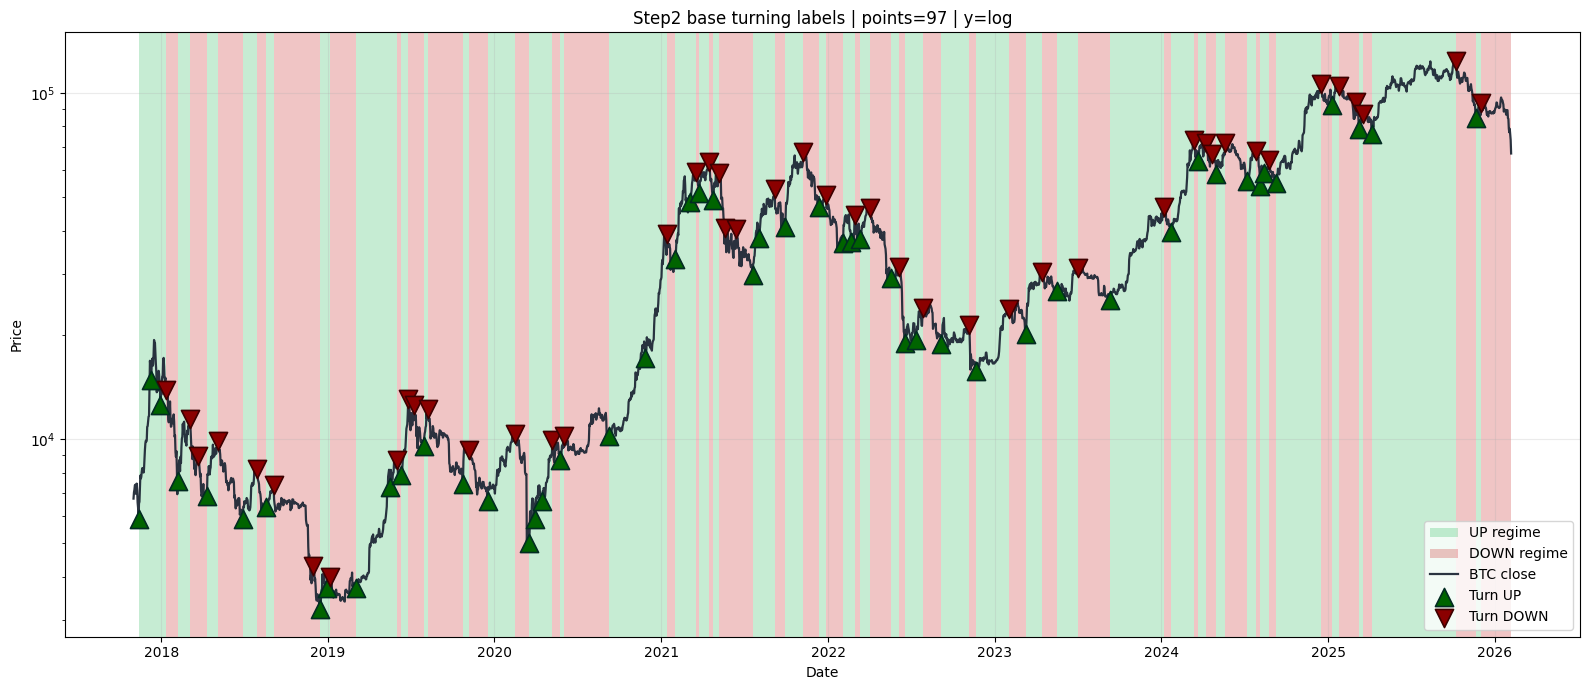

In [4]:
# ============================================================================
# Step 1) Load market data and generate turning-point labels.
# ============================================================================
# We always produce labels on the same date window used for features, so model
# input/output stay strictly aligned by timestamp.

latest_parquet_date = get_latest_date()
print('Latest parquet date before load:', latest_parquet_date.date() if latest_parquet_date is not None else 'unknown')

df_market_full = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE_MARKET,
    verbose=VERBOSE,
)

# Optional: append today's live price so the newest date is included in test scope.
if INCLUDE_TODAY_LIVE_ROW:
    today_ts = pd.to_datetime(FORCE_TODAY_DATE).normalize() if FORCE_TODAY_DATE else pd.Timestamp.now(tz='UTC').tz_localize(None).normalize()
    last_ts = pd.to_datetime(df_market_full['date']).max().normalize()

    if today_ts > last_ts:
        live_price = None
        try:
            live_price = float(fetch_current_btc_price_usd(timeout=int(LIVE_TODAY_TIMEOUT)))
            print(f"[live] BTC spot fetched for {today_ts.date()}: {live_price:.2f}")
        except Exception as e:
            live_price = float(pd.to_numeric(df_market_full['close'], errors='coerce').dropna().iloc[-1])
            print(f"[warn] Live price fetch failed, fallback to last close for {today_ts.date()}: {live_price:.2f} | err={e}")

        df_market_full = pd.concat(
            [
                df_market_full,
                pd.DataFrame({'date': [today_ts], 'close': [live_price]}),
            ],
            ignore_index=True,
        )
        df_market_full['date'] = pd.to_datetime(df_market_full['date'])
        df_market_full['close'] = pd.to_numeric(df_market_full['close'], errors='coerce')
        df_market_full = (
            df_market_full
            .dropna(subset=['date', 'close'])
            .sort_values('date')
            .drop_duplicates(subset=['date'], keep='last')
            .reset_index(drop=True)
        )
        print('[live] Appended provisional row for', today_ts.date())
    else:
        print('[live] Today row already present or not needed:', today_ts.date(), '| last_loaded:', last_ts.date())

loaded_max_date = pd.to_datetime(df_market_full['date']).max()
print('Loaded market max date:', loaded_max_date.date(), '| rows full:', len(df_market_full))

if latest_parquet_date is not None and loaded_max_date.date() < latest_parquet_date.date():
    print('[warn] Loaded slice is older than parquet max date. Check cache policy and rerun.')

df_market = _slice_by_window(
    df=df_market_full,
    mode=DATA_WINDOW_MODE,
    last_n_days=DATA_LAST_N_DAYS,
    range_pct=DATA_RANGE_PCT,
)

print(
    'Market window:',
    pd.to_datetime(df_market['date']).min().date(),
    '->',
    pd.to_datetime(df_market['date']).max().date(),
    '| rows:',
    len(df_market),
)

# Turning labels are built with your selected future+past confirmation settings.
df_candidates, df_turning_points, df_regimes = label_turning_points(df_market, TURN_CFG)

n_up = int((df_turning_points['turning_direction'] == 1).sum()) if not df_turning_points.empty else 0
n_down = int((df_turning_points['turning_direction'] == -1).sum()) if not df_turning_points.empty else 0
print('Turning points:', len(df_turning_points), '| UP:', n_up, '| DOWN:', n_down)
print('Regimes:', len(df_regimes))

display(df_turning_points.head(20))

fig, ax = plot_turning_points_chart(
    df_market=df_market,
    df_turning_points=df_turning_points,
    df_regimes=df_regimes,
    title=f'Step2 base turning labels | points={len(df_turning_points)} | y={PLOT_Y_SCALE}',
    y_scale=PLOT_Y_SCALE,
)
plt.show()


In [5]:
# ============================================================================
# Step 2) Build full astro feature matrix and print a transparent feature log.
# ============================================================================
# This is the core model input: only astro-based features plus date key.
# We explicitly print feature groups so each run is auditable.

df_features = build_turning_astro_feature_set(
    df_market=df_market,
    birth_dt_utc=BIRTH_DT_UTC,
    cfg=ASTRO_CFG,
    cache_namespace='research2_turning_step2',
    use_cache=USE_CACHE_FEATURES,
    verbose=VERBOSE,
    progress=PROGRESS,
)

feature_cols = [c for c in df_features.columns if c != 'date']
df_groups = summarize_feature_groups(feature_cols, examples_per_group=3)

print('===== Feature Input Log =====')
print('Birth datetime used:', BIRTH_DT_UTC)
print('Feature matrix rows:', len(df_features))
print('Feature matrix cols:', len(feature_cols))
print('Feature groups (name + examples):')
print(df_groups.to_string(index=False))


📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3020/3020 [00:00<00:00, 14674.30it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3020/3020 [00:00<00:00, 27588.94it/s]


✅ Объединено: 78520 записей из 2 систем координат
📐 Расчёт GEO-аспектов (orb×0.1)...


Calculating aspects (orb=0.1): 100%|██████████| 3020/3020 [00:00<00:00, 54380.04it/s]


☀️ Расчёт HELIO-аспектов (orb×0.1)...


Calculating aspects (orb=0.1): 100%|██████████| 3020/3020 [00:00<00:00, 43564.89it/s]


✅ Объединено 28830 аспектов из 2 систем


Calculating phases & elongations: 100%|██████████| 3020/3020 [00:00<00:00, 209095.53it/s]


✅ Рассчитано 3020 дней: фаза Луны + элонгации планет


/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_sin"] = np.sin(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_cos"] = np.cos(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

✅ Cached: research2_turning_step2_ephem__ephemeris_features__2017-11-01_both_orb0.1_phases__ad5710c1.parquet (5.67 MB)
Ephemeris feature set ready: 3020 days, 1460 features


Calculating transits (orb=0.1): 100%|██████████| 3020/3020 [00:00<00:00, 27836.30it/s]


✅ Cached: research2_turning_step2_transits__transit_to_natal_features__2017-11-01_orb0.1__86a8f01a.parquet (1.16 MB)
Transit->natal features ready: rows=3020 cols=1210 birth_dt_utc=2009-10-10T18:15:05Z
Full turning astro feature set: rows=3020 cols=2670 birth_dt_utc=2009-10-10T18:15:05Z cfg={'coord_mode': 'both', 'orb_mult': 0.1, 'include_pair_aspects': True, 'include_phases': True, 'include_transit_aspects': True, 'add_trig_for_longitudes': True, 'add_trig_for_moon_phase': True, 'add_trig_for_elongations': True, 'schema': 'turning_astro_full_v1'}
===== Feature Input Log =====
Birth datetime used: 2009-10-10T18:15:05Z
Feature matrix rows: 3020
Feature matrix cols: 2670
Feature groups (name + examples):
             group  n_features                                                                                                                                            example_cols
   pair_aspect_hit         614                      aspect_hit_geo_Jupiter__geo_Lilith__Sextile, aspect_h

In [6]:
# ============================================================================
# Step 3) Build target frames for all sparse-label strategies, pick one mode.
# ============================================================================
# Why build all modes every run?
# - It lets us compare sample density and class balance before choosing.
# - Sparse labeling is usually the bottleneck in turning-point tasks.

target_frames: dict[str, pd.DataFrame] = {}
for mode in ['point_only', 'window_kernel', 'segment_midpoint']:
    target_frames[mode] = build_turning_target_frame(
        df_market=df_market,
        df_turning_points=df_turning_points,
        mode=mode,
        window_radius_days=WINDOW_RADIUS_DAYS,
        window_distance_power=WINDOW_DISTANCE_POWER,
        segment_center_power=SEGMENT_CENTER_POWER,
        segment_direction_anchor=SEGMENT_DIRECTION_ANCHOR,
        include_last_open_segment=SEGMENT_INCLUDE_LAST_OPEN,
        segment_open_tail_direction_mode=TAIL_DIRECTION_MODE,
        segment_open_tail_min_move_pct=TAIL_MIN_MOVE_PCT,
        min_weight=MIN_SAMPLE_WEIGHT,
        use_amplitude_weight=USE_AMPLITUDE_WEIGHT,
        use_numba=USE_NUMBA_TARGETS,
    )

print('===== Target Mode Diagnostics =====')
for mode, df_t in target_frames.items():
    if len(df_t):
        d0 = pd.to_datetime(df_t['date']).min().date()
        d1 = pd.to_datetime(df_t['date']).max().date()
    else:
        d0, d1 = 'na', 'na'

    print(f'[{mode}] rows={len(df_t)} | date_range={d0} -> {d1}')
    if len(df_t):
        _print_class_stats(df_t)
        med_w = float(pd.to_numeric(df_t['sample_weight'], errors='coerce').median())
        print(f'median_weight={med_w:.4f}')
    print('-')

df_target = target_frames[TARGET_MODE].copy()

# Safety check: target semantics vs base regime semantics from turning points.
if len(df_target) > 0 and len(df_turning_points) > 0 and 'turning_direction' in df_target.columns:
    _base = df_turning_points[['date', 'turning_direction']].copy()
    _base['date'] = pd.to_datetime(_base['date'])
    _base = _base.sort_values('date').drop_duplicates('date').reset_index(drop=True)

    _cmp = df_target[['date', 'turning_direction']].copy()
    _cmp['date'] = pd.to_datetime(_cmp['date'])
    _cmp = _cmp.sort_values('date').reset_index(drop=True)
    _cmp = pd.merge_asof(_cmp, _base.rename(columns={'turning_direction': 'base_regime_dir'}), on='date', direction='backward')
    _cmp = _cmp.dropna(subset=['base_regime_dir']).copy()

    _cmp['same'] = (_cmp['turning_direction'].astype(int) == _cmp['base_regime_dir'].astype(int)).astype(int)
    _cmp['opposite'] = (_cmp['turning_direction'].astype(int) == -_cmp['base_regime_dir'].astype(int)).astype(int)
    print(
        'Target vs base regime alignment:',
        f"same={_cmp['same'].mean():.3f}",
        f"opposite={_cmp['opposite'].mean():.3f}",
        f"rows={len(_cmp)}",
    )

    if TARGET_MODE == 'segment_midpoint' and SEGMENT_DIRECTION_ANCHOR == 'current_turn' and _cmp['same'].mean() < 0.80:
        print('[warn] Unexpected low alignment for current_turn semantics. Restart kernel and rerun all cells.')

df_dataset = merge_features_with_turning_target(
    df_features=df_features,
    df_target=df_target,
    df_market_close=df_market[['date', 'close']],
)

meta_cols = {'date', 'target', 'turning_direction', 'sample_weight', 'target_mode', 'event_index', 'segment_index', 'close'}
feature_cols_dataset = [c for c in df_dataset.columns if c not in meta_cols]

print('===== Active Dataset =====')
print('TARGET_MODE:', TARGET_MODE)
print('rows:', len(df_dataset), '| feature_cols:', len(feature_cols_dataset))
_print_class_stats(df_dataset)
display(df_dataset[['date', 'target', 'turning_direction', 'sample_weight', 'target_mode']].head(20))


===== Target Mode Diagnostics =====
[point_only] rows=97 | date_range=2017-11-12 -> 2025-12-03
rows=97 | raw DOWN=46 (47.4%) | raw UP=51 (52.6%)
weighted DOWN=63.57 (52.7%) | weighted UP=57.09 (47.3%)
median_weight=1.0000
-
[window_kernel] rows=1464 | date_range=2017-11-04 -> 2025-12-11
rows=1464 | raw DOWN=694 (47.4%) | raw UP=770 (52.6%)
weighted DOWN=451.56 (52.8%) | weighted UP=403.41 (47.2%)
median_weight=0.4187
-
[segment_midpoint] rows=3009 | date_range=2017-11-12 -> 2026-02-06
rows=3009 | raw DOWN=1390 (46.2%) | raw UP=1619 (53.8%)
weighted DOWN=591.39 (31.4%) | weighted UP=1290.00 (68.6%)
median_weight=0.3798
-
Target vs base regime alignment: same=0.974 opposite=0.026 rows=3009
===== Active Dataset =====
TARGET_MODE: segment_midpoint
rows: 3009 | feature_cols: 2670
rows=3009 | raw DOWN=1390 (46.2%) | raw UP=1619 (53.8%)
weighted DOWN=591.39 (31.4%) | weighted UP=1290.00 (68.6%)


,date,target,turning_direction,sample_weight,target_mode
0,2017-11-12,1,1,0.050000,segment_midpoint
1,2017-11-13,1,1,0.050000,segment_midpoint
2,2017-11-14,1,1,0.141330,segment_midpoint
3,2017-11-15,1,1,0.270384,segment_midpoint
4,2017-11-16,1,1,0.428433,segment_midpoint
5,2017-11-17,1,1,0.612265,segment_midpoint
6,2017-11-18,1,1,0.819651,segment_midpoint
7,2017-11-19,1,1,1.048924,segment_midpoint
8,2017-11-20,1,1,1.298767,segment_midpoint
9,2017-11-21,1,1,1.568105,segment_midpoint


In [7]:
# ============================================================================
# Step 4) Time split + train XGBoost with weighted samples.
# ============================================================================
# We combine two weighting ideas:
# 1) class-balance weight (helps minority class recall),
# 2) label-strength weight from target builder (important turns get more weight).

feature_cols_model = [
    c for c in df_dataset.columns
    if c not in {
        'date', 'target', 'close', 'turning_direction', 'sample_weight',
        'target_mode', 'event_index', 'segment_index'
    }
]

split = make_classic_split(df_dataset, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO)
print('Split meta:', describe_split(df_dataset, split))

train_df = df_dataset.iloc[split.train_idx].copy().reset_index(drop=True)
val_df = df_dataset.iloc[split.val_idx].copy().reset_index(drop=True)
test_df = df_dataset.iloc[split.test_idx].copy().reset_index(drop=True)

print('[train]')
_print_class_stats(train_df)
print('[val]')
_print_class_stats(val_df)
print('[test]')
_print_class_stats(test_df)

X_train = train_df[feature_cols_model].to_numpy(dtype=float)
y_train = train_df['target'].to_numpy(dtype=np.int32)
X_val = val_df[feature_cols_model].to_numpy(dtype=float)
y_val = val_df['target'].to_numpy(dtype=np.int32)
X_test = test_df[feature_cols_model].to_numpy(dtype=float)
y_test = test_df['target'].to_numpy(dtype=np.int32)

w_train_base = pd.to_numeric(train_df['sample_weight'], errors='coerce').fillna(1.0).to_numpy(dtype=float)
w_val_base = pd.to_numeric(val_df['sample_weight'], errors='coerce').fillna(1.0).to_numpy(dtype=float)
w_test_base = pd.to_numeric(test_df['sample_weight'], errors='coerce').fillna(1.0).to_numpy(dtype=float)

w_train_class = compute_sample_weight(class_weight='balanced', y=y_train).astype(float)
w_val_class = compute_sample_weight(class_weight='balanced', y=y_val).astype(float)
w_test_class = compute_sample_weight(class_weight='balanced', y=y_test).astype(float)

w_train = w_train_base * w_train_class
w_val = w_val_base * w_val_class
w_test = w_test_base * w_test_class


def _make_model(device_name: str) -> XGBBaseline:
    """Create model instance so we can retry with CPU if GPU training fails."""
    return XGBBaseline(
        n_classes=2,
        device=device_name,
        random_state=42,
        early_stopping_rounds=MODEL_EARLY_STOP,
        n_estimators=MODEL_N_ESTIMATORS,
        max_depth=MODEL_MAX_DEPTH,
        learning_rate=MODEL_LEARNING_RATE,
        subsample=MODEL_SUBSAMPLE,
        colsample_bytree=MODEL_COLSAMPLE,
        tree_method='hist',
        eval_metric='logloss',
    )


model = _make_model(MODEL_DEVICE)
actual_device = MODEL_DEVICE

try:
    model.fit(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        feature_names=feature_cols_model,
        sample_weight=w_train,
        sample_weight_val=w_val,
    )
except Exception as err:
    if str(MODEL_DEVICE).startswith('cuda'):
        print('[warn] CUDA training failed, retrying on CPU. Error:', repr(err))
        model = _make_model('cpu')
        actual_device = 'cpu'
        model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_names=feature_cols_model,
            sample_weight=w_train,
            sample_weight_val=w_val,
        )
    else:
        raise


def _predict_proba_up_safe(model_obj: XGBBaseline, X: np.ndarray) -> np.ndarray:
    """Return P(UP) with safe fallback for constant-class edge case."""
    if getattr(model_obj, 'constant_class', None) is not None:
        c = int(model_obj.constant_class)
        return np.full(X.shape[0], 1.0 if c == 1 else 0.0, dtype=float)

    Xs = model_obj.scaler.transform(X)
    return model_obj.model.predict_proba(Xs)[:, 1]


p_train = _predict_proba_up_safe(model, X_train)
p_val = _predict_proba_up_safe(model, X_val)
p_test = _predict_proba_up_safe(model, X_test)

best_t, best_score = tune_threshold_with_balance(
    y_val=y_val,
    proba_up=p_val,
    gap_penalty=THRESHOLD_GAP_PENALTY,
    prior_penalty=THRESHOLD_PRIOR_PENALTY,
    thresholds=THRESH_GRID,
)

y_pred_train = (p_train >= best_t).astype(np.int32)
y_pred_val = (p_val >= best_t).astype(np.int32)
y_pred_test = (p_test >= best_t).astype(np.int32)

m_train = compute_binary_metrics(y_train, y_pred_train)
m_val = compute_binary_metrics(y_val, y_pred_val)
m_test = compute_binary_metrics(y_test, y_pred_test)
sig_test = compute_statistical_significance(y_test, y_pred_test, random_baseline=0.5)

print('===== Model Result =====')
print('target_mode:', TARGET_MODE)
print('device_requested:', MODEL_DEVICE, '| device_used:', actual_device)
print('numba_targets:', USE_NUMBA_TARGETS, '| numba_available:', NUMBA_AVAILABLE)
print(f'best_threshold={best_t:.4f} | val_objective={best_score:.6f}')
print('train:', m_train)
print('val:', m_val)
print('test:', m_test)
print('recall_min by split | train:', f"{m_train['recall_min']:.4f}", '| val:', f"{m_val['recall_min']:.4f}", '| test:', f"{m_test['recall_min']:.4f}")
print('test_significance:', sig_test)


Split meta: {'protocol': 'classic_70_15_15', 'fold': 1, 'train_rows': 1504, 'val_rows': 602, 'test_rows': 903, 'train_start': Timestamp('2017-11-12 00:00:00'), 'train_end': Timestamp('2021-12-24 00:00:00'), 'val_start': Timestamp('2021-12-25 00:00:00'), 'val_end': Timestamp('2023-08-18 00:00:00'), 'test_start': Timestamp('2023-08-19 00:00:00'), 'test_end': Timestamp('2026-02-06 00:00:00')}
[train]
rows=1504 | raw DOWN=770 (51.2%) | raw UP=734 (48.8%)
weighted DOWN=372.07 (38.6%) | weighted UP=593.06 (61.4%)
[val]
rows=602 | raw DOWN=280 (46.5%) | raw UP=322 (53.5%)
weighted DOWN=120.13 (43.7%) | weighted UP=155.03 (56.3%)
[test]
rows=903 | raw DOWN=340 (37.7%) | raw UP=563 (62.3%)
weighted DOWN=99.19 (15.5%) | weighted UP=541.91 (84.5%)


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [09:21:59] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


===== Model Result =====
target_mode: segment_midpoint
device_requested: cuda | device_used: cuda
numba_targets: True | numba_available: True
best_threshold=0.6400 | val_objective=0.465498
train: {'accuracy': 0.84375, 'balanced_accuracy': 0.8404596765632188, 'mcc': 0.7115670854594618, 'f1_macro': 0.839771298734681, 'precision_down': 0.7754891864057673, 'precision_up': 0.9681050656660413, 'recall_down': 0.977922077922078, 'recall_up': 0.7029972752043597, 'recall_min': 0.7029972752043597, 'recall_gap': 0.27492480271771824, 'support': 1504}
val: {'accuracy': 0.48006644518272423, 'balanced_accuracy': 0.48066770186335406, 'mcc': -0.038578046792816796, 'f1_macro': 0.4797434417787889, 'precision_down': 0.44625407166123776, 'precision_up': 0.5152542372881356, 'recall_down': 0.48928571428571427, 'recall_up': 0.4720496894409938, 'recall_min': 0.4720496894409938, 'recall_gap': 0.017236024844720477, 'support': 602}
test: {'accuracy': 0.512735326688815, 'balanced_accuracy': 0.5504048688747257, 'mcc

Top thresholds on validation (this table is VAL only, not TRAIN/TEST):


,threshold,score,recall_min,recall_gap,prior_gap,pred_up_share,true_up_share,accuracy,balanced_accuracy,mcc,f1_macro
0,0.640,0.465498,0.472050,0.017236,0.044850,0.490033,0.534884,0.480066,0.480668,-0.038578,0.479743
1,0.635,0.351932,0.385714,0.129814,0.026578,0.561462,0.534884,0.455150,0.450621,-0.099270,0.450045
2,0.645,0.325015,0.375776,0.177795,0.126246,0.408638,0.534884,0.458472,0.464674,-0.071687,0.456739
3,0.630,0.237061,0.328571,0.339130,0.134551,0.669435,0.534884,0.509967,0.498137,-0.003951,0.488619
4,0.620,0.188150,0.292857,0.387267,0.157807,0.692691,0.534884,0.500000,0.486491,-0.029209,0.472691
5,0.625,0.188150,0.292857,0.387267,0.157807,0.692691,0.534884,0.500000,0.486491,-0.029209,0.472691
6,0.615,-0.226955,0.010714,0.871273,0.397010,0.931894,0.534884,0.476744,0.446351,-0.212435,0.330977
7,0.605,-0.232111,0.010714,0.889907,0.406977,0.941860,0.534884,0.486711,0.455668,-0.188987,0.335733
8,0.610,-0.232111,0.010714,0.889907,0.406977,0.941860,0.534884,0.486711,0.455668,-0.188987,0.335733
9,0.595,-0.241206,0.003571,0.897050,0.410299,0.945183,0.534884,0.483389,0.452096,-0.209939,0.328672


Top thresholds on test (diagnostic only; threshold is still tuned on VAL):


,threshold,score,recall_min,recall_gap,prior_gap,pred_up_share,true_up_share,accuracy,balanced_accuracy,mcc,f1_macro
0,0.625,0.510306,0.517647,0.006332,0.115172,0.508306,0.623477,0.521595,0.520813,0.040342,0.513140
1,0.620,0.501366,0.517647,0.047184,0.089701,0.533776,0.623477,0.547065,0.541239,0.080107,0.535581
2,0.630,0.438980,0.468917,0.086966,0.163898,0.459579,0.623477,0.501661,0.512399,0.024110,0.498200
3,0.635,0.418423,0.468917,0.163436,0.192691,0.430786,0.623477,0.530454,0.550635,0.099087,0.529067
4,0.640,0.308422,0.397869,0.305073,0.263566,0.359911,0.623477,0.512735,0.550405,0.101763,0.512601
5,0.645,0.259053,0.360568,0.348255,0.289037,0.334441,0.623477,0.491694,0.534696,0.071263,0.490793
6,0.615,-0.021734,0.185294,0.772077,0.280177,0.903654,0.623477,0.666667,0.571333,0.234265,0.538404
7,0.605,-0.064283,0.152941,0.809759,0.295681,0.919158,0.623477,0.657807,0.557820,0.205544,0.514996
8,0.610,-0.064283,0.152941,0.809759,0.295681,0.919158,0.623477,0.657807,0.557820,0.205544,0.514996
9,0.600,-0.198629,0.047059,0.915641,0.335548,0.959025,0.623477,0.617940,0.504879,0.023852,0.421727


===== Test Labeling Snapshot =====
rows: 903 | accuracy: 0.513
FULL test period: 2023-08-19 -> 2026-02-06
Last market date: 2026-02-06 | last labeled date: 2026-02-06 | unlabeled tail days: 0
Confusion table (test):
Pred  DOWN   UP
True           
DOWN   239  101
UP     339  224
Known unlabeled tail rows: 0
Forecast horizon: 2026-02-07 -> 2026-03-08 | rows: 30
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 30/30 [00:00<00:00, 19731.71it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 30/30 [00:00<00:00, 20311.40it/s]


✅ Объединено: 780 записей из 2 систем координат
📐 Расчёт GEO-аспектов (orb×0.1)...


Calculating aspects (orb=0.1): 100%|██████████| 30/30 [00:00<00:00, 42055.19it/s]


☀️ Расчёт HELIO-аспектов (orb×0.1)...


Calculating aspects (orb=0.1): 100%|██████████| 30/30 [00:00<00:00, 34155.57it/s]


✅ Объединено 280 аспектов из 2 систем


Calculating phases & elongations: 100%|██████████| 30/30 [00:00<00:00, 100502.49it/s]
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_sin"] = np.sin(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_{suffix}_cos"] = np.cos(rad)
/home/rut/ostrofun/RESEARCH2/Moon_cycles/ephemeris_data.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

✅ Рассчитано 30 дней: фаза Луны + элонгации планет
✅ Cached: research2_turning_step2_future_ephem__ephemeris_features__2026-02-07_both_orb0.1_phases__c76af6c6.parquet (0.26 MB)
Ephemeris feature set ready: 30 days, 316 features


Calculating transits (orb=0.1): 100%|██████████| 30/30 [00:00<00:00, 24779.27it/s]

✅ Cached: research2_turning_step2_future_transits__transit_to_natal_features__2026-02-07_orb0.1__a16a077c.parquet (0.05 MB)
Transit->natal features ready: rows=30 cols=56 birth_dt_utc=2009-10-10T18:15:05Z
Full turning astro feature set:


/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_future_features[col] = 0.0
/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_future_features[col] = 0.0
/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

 rows=30 cols=372 birth_dt_utc=2009-10-10T18:15:05Z cfg={'coord_mode': 'both', 'orb_mult': 0.1, 'include_pair_aspects': True, 'include_phases': True, 'include_transit_aspects': True, 'add_trig_for_longitudes': True, 'add_trig_for_moon_phase': True, 'add_trig_for_elongations': True, 'schema': 'turning_astro_full_v1'}


/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_future_features[col] = 0.0
/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_future_features[col] = 0.0
/tmp/ipykernel_1127856/714087033.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

===== Future Forecast Summary =====
UP forecasts: 11
DOWN forecasts: 19
mean P(UP): 0.6303485115369161


,date,close,true_label,pred_label,proba_up
0,2026-01-26 00:00:00,86548.322135,DOWN,DOWN,0.630674
1,2026-01-27 00:00:00,88307.861207,DOWN,DOWN,0.630674
2,2026-01-28 00:00:00,89204.222396,DOWN,DOWN,0.630674
3,2026-01-29 00:00:00,89162.097016,DOWN,DOWN,0.630674
4,2026-01-30 00:00:00,84570.409061,DOWN,DOWN,0.630674
5,2026-01-31 00:00:00,84141.77857,DOWN,DOWN,0.630674
6,2026-02-01 00:00:00,78725.858539,DOWN,DOWN,0.630674
7,2026-02-02 00:00:00,76937.064066,DOWN,DOWN,0.630674
8,2026-02-03 00:00:00,78767.658153,DOWN,DOWN,0.630674
9,2026-02-04 00:00:00,75638.956702,DOWN,DOWN,0.630674


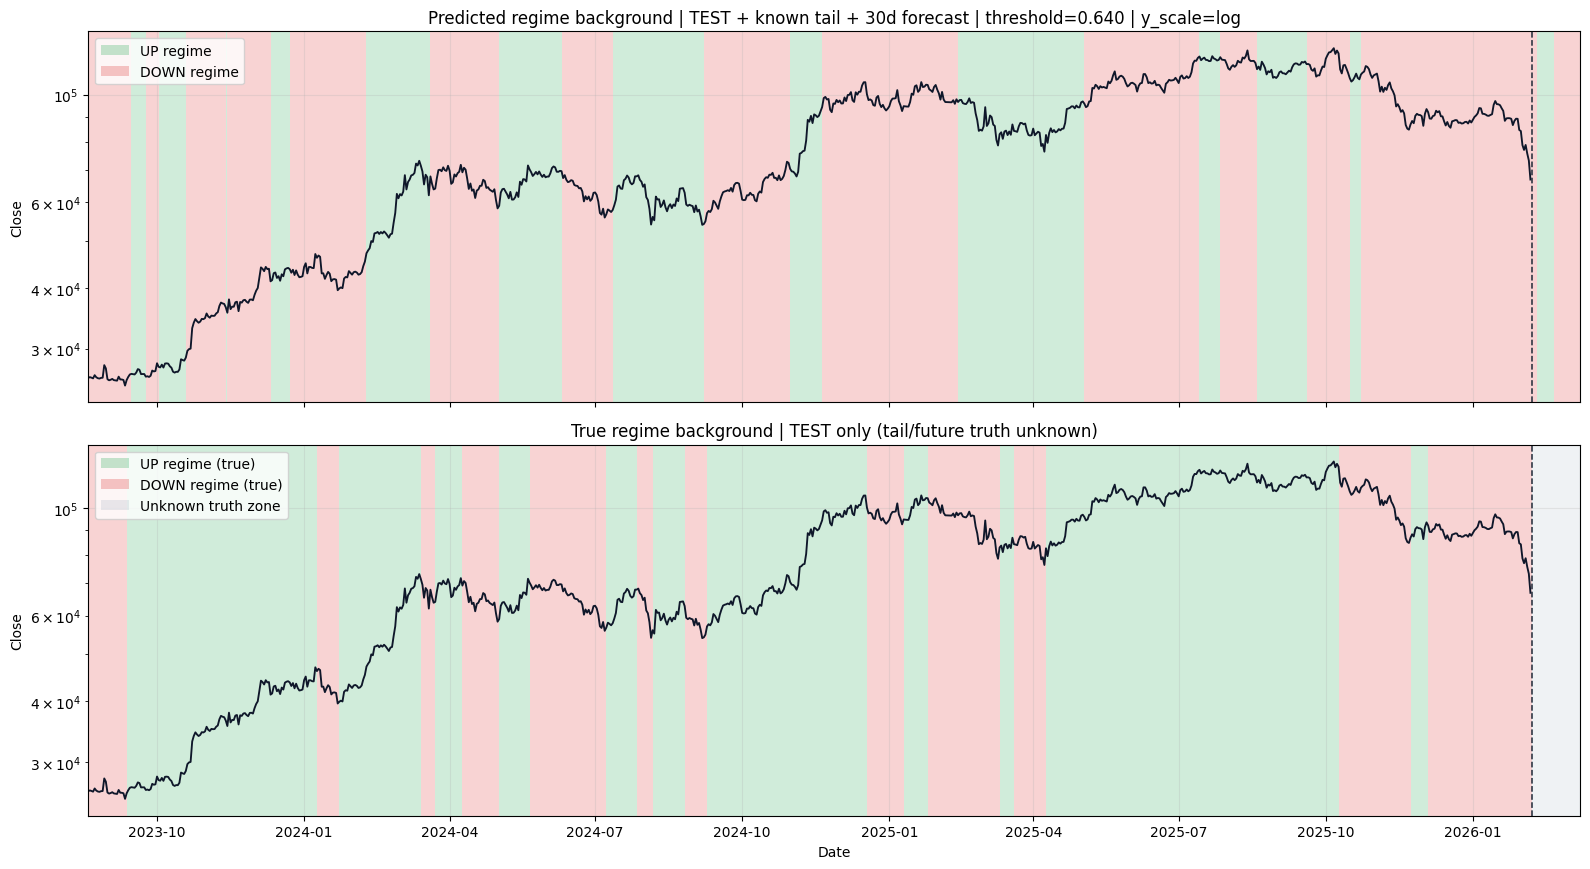

In [8]:
# ============================================================================
# Step 5) Test labeling + 30-day forecast in ONE combined view.
# ============================================================================
# This block is for interpretability in one place:
# - full test-period true/pred diagnostics,
# - immediate continuation with one-month future forecast (astro-only features),
# - single combined chart where forecast is attached to test timeline.

df_thr = evaluate_threshold_grid(
    y_true=y_val,
    proba_up=p_val,
    gap_penalty=THRESHOLD_GAP_PENALTY,
    prior_penalty=THRESHOLD_PRIOR_PENALTY,
    thresholds=THRESH_GRID,
)

print('Top thresholds on validation (this table is VAL only, not TRAIN/TEST):')
display(df_thr.head(12))

df_thr_test = evaluate_threshold_grid(
    y_true=y_test,
    proba_up=p_test,
    gap_penalty=THRESHOLD_GAP_PENALTY,
    prior_penalty=THRESHOLD_PRIOR_PENALTY,
    thresholds=THRESH_GRID,
)
print('Top thresholds on test (diagnostic only; threshold is still tuned on VAL):')
display(df_thr_test.head(12))

# --- Test snapshot.
df_test_view = pd.DataFrame(
    {
        'date': pd.to_datetime(test_df['date']),
        'close': pd.to_numeric(test_df['close'], errors='coerce'),
        'true_target': y_test.astype(np.int32),
        'pred_target': y_pred_test.astype(np.int32),
        'proba_up': p_test.astype(float),
        'sample_weight': w_test.astype(float),
    }
).sort_values('date').reset_index(drop=True)

df_test_view['true_label'] = np.where(df_test_view['true_target'] == 1, 'UP', 'DOWN')
df_test_view['pred_label'] = np.where(df_test_view['pred_target'] == 1, 'UP', 'DOWN')
df_test_view['is_correct'] = (df_test_view['true_target'] == df_test_view['pred_target']).astype(int)

print('===== Test Labeling Snapshot =====')
print('rows:', len(df_test_view), '| accuracy:', f"{df_test_view['is_correct'].mean():.3f}")
print('FULL test period:', df_test_view['date'].min().date(), '->', df_test_view['date'].max().date())
last_market_date = pd.to_datetime(df_market['date']).max().date()
last_labeled_date = pd.to_datetime(df_test_view['date']).max().date()
print('Last market date:', last_market_date, '| last labeled date:', last_labeled_date, '| unlabeled tail days:', (last_market_date - last_labeled_date).days)

cm_table = pd.crosstab(
    df_test_view['true_label'],
    df_test_view['pred_label'],
    rownames=['True'],
    colnames=['Pred'],
    dropna=False,
)
print('Confusion table (test):')
print(cm_table.to_string())

# --- Known but unlabeled market tail (after last true label, before future).
last_labeled_ts = pd.to_datetime(df_test_view['date']).max()
df_tail_features = df_features[pd.to_datetime(df_features['date']) > last_labeled_ts].copy()

df_known_tail_pred = pd.DataFrame(columns=['date', 'proba_up', 'pred_target', 'pred_label', 'close'])
if len(df_tail_features) > 0:
    # Align once to model schema to avoid fragmented DataFrame inserts.
    df_tail_features = (
        df_tail_features
        .reindex(columns=['date'] + feature_cols_model, fill_value=0.0)
        .copy()
        .sort_values('date')
        .reset_index(drop=True)
    )
    X_tail = df_tail_features[feature_cols_model].to_numpy(dtype=float)
    p_tail = _predict_proba_up_safe(model, X_tail)
    y_tail = (p_tail >= best_t).astype(np.int32)

    df_known_tail_pred = pd.DataFrame(
        {
            'date': pd.to_datetime(df_tail_features['date']),
            'proba_up': p_tail.astype(float),
            'pred_target': y_tail.astype(np.int32),
        }
    )
    df_known_tail_pred['pred_label'] = np.where(df_known_tail_pred['pred_target'] == 1, 'UP', 'DOWN')
    df_known_tail_pred = pd.merge(
        df_known_tail_pred,
        df_market[['date', 'close']].assign(date=lambda x: pd.to_datetime(x['date'])),
        on='date',
        how='left',
    )

print('Known unlabeled tail rows:', len(df_known_tail_pred))
if len(df_known_tail_pred) > 0:
    print('Known tail period:', df_known_tail_pred['date'].min().date(), '->', df_known_tail_pred['date'].max().date())

# --- Future forecast (same trained model, astro-only future features).
last_known_date = pd.to_datetime(df_market['date']).max().normalize()
future_dates = pd.date_range(
    start=last_known_date + pd.Timedelta(days=1),
    periods=int(FUTURE_FORECAST_DAYS),
    freq=FUTURE_FREQ,
)

print('Forecast horizon:', future_dates.min().date(), '->', future_dates.max().date(), '| rows:', len(future_dates))

df_future_calendar = pd.DataFrame({'date': future_dates})

df_future_features = build_turning_astro_feature_set(
    df_market=df_future_calendar,
    birth_dt_utc=BIRTH_DT_UTC,
    cfg=ASTRO_CFG,
    cache_namespace='research2_turning_step2_future',
    use_cache=USE_CACHE_FEATURES,
    verbose=VERBOSE,
    progress=PROGRESS,
)

# Align once to model schema to avoid fragmented DataFrame inserts.
df_future_features = (
    df_future_features
    .reindex(columns=['date'] + feature_cols_model, fill_value=0.0)
    .copy()
)
X_future = df_future_features[feature_cols_model].to_numpy(dtype=float)

p_future = _predict_proba_up_safe(model, X_future)
y_pred_future = (p_future >= best_t).astype(np.int32)

df_future_pred = pd.DataFrame(
    {
        'date': pd.to_datetime(df_future_features['date']),
        'proba_up': p_future.astype(float),
        'pred_target': y_pred_future.astype(np.int32),
    }
).sort_values('date').reset_index(drop=True)
df_future_pred['pred_label'] = np.where(df_future_pred['pred_target'] == 1, 'UP', 'DOWN')

print('===== Future Forecast Summary =====')
n_future = int(len(df_future_pred))
n_up = int((df_future_pred['pred_target'] == 1).sum())
n_down = int((df_future_pred['pred_target'] == 0).sum())
print('threshold for UP:', float(best_t))
print('UP forecasts:', n_up)
print('DOWN forecasts:', n_down)
print('UP share:', (n_up / max(n_future, 1)))
print('mean P(UP):', float(df_future_pred['proba_up'].mean()))
if n_up > 0:
    print('mean P(UP) on UP-pred rows:', float(df_future_pred.loc[df_future_pred['pred_target'] == 1, 'proba_up'].mean()))
if n_down > 0:
    print('mean P(UP) on DOWN-pred rows:', float(df_future_pred.loc[df_future_pred['pred_target'] == 0, 'proba_up'].mean()))
print('P(UP) quantiles:', df_future_pred['proba_up'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).to_dict())

# Compact transition table: last test + known tail + future head.
df_transition = pd.concat(
    [
        df_test_view[['date', 'close', 'true_label', 'pred_label', 'proba_up']].tail(12),
        df_known_tail_pred[['date', 'close', 'pred_label', 'proba_up']].assign(true_label='NA_UNLABELED').tail(22),
        pd.DataFrame(
            {
                'date': df_future_pred['date'].head(12),
                'close': np.nan,
                'true_label': 'NA_FUTURE',
                'pred_label': df_future_pred['pred_label'].head(12),
                'proba_up': df_future_pred['proba_up'].head(12),
            }
        ),
    ],
    ignore_index=True,
)
display(df_transition)

# Price timeline for top panel: test start -> latest known market date.
test_start = pd.to_datetime(df_test_view['date']).min()
df_price_for_top = (
    df_market[['date', 'close']]
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .query('date >= @test_start')
    .sort_values('date')
    .reset_index(drop=True)
)

# One combined chart: predicted background spans test + known tail + future.
_plot_test_label_diagnostics(
    df_view=df_test_view,
    threshold=best_t,
    y_scale=PLOT_Y_SCALE,
    df_known_tail_pred=df_known_tail_pred,
    df_future_pred=df_future_pred,
    df_price_for_top=df_price_for_top,
    compare_scope=REGIME_COMPARE_SCOPE,
)


===== Trading Signal Setup =====
trading_position_mode: long_short
p_test min/mean/max: 0.5925955176353455 0.6292403936386108 0.646493136882782
threshold_down=0.640 | threshold_up=0.640 | neutral_band=0.030
fallback_to_binary_used: False
signal counts -> long(1)=325, short(-1)=578, flat(0)=0, neutral(NaN)=0
===== Trading Backtest Metrics (Test only) =====
return=51.160% | hold_return=155.628% | excess=-40.867%
max_drawdown=45.29% | ulcer_index=28.79 | trades=25 | winrate=48.0% | exposure=99.9%
exposure_long=36.0% | exposure_short=63.9%


,date,close,signal,position,equity,hold_equity
0,2023-08-19,26099.4,-1.0,-1,0.999000,0.999000
1,2023-08-20,26190.8,-1.0,-1,0.995502,1.002498
2,2023-08-21,26126.0,-1.0,-1,0.997965,1.000018
3,2023-08-22,26039.9,-1.0,-1,1.001253,0.996723
4,2023-08-23,26436.2,-1.0,-1,0.986015,1.011892
5,2023-08-24,26177.0,-1.0,-1,0.995683,1.001970
6,2023-08-25,26057.2,-1.0,-1,1.000240,0.997385
7,2023-08-26,26017.1,-1.0,-1,1.001779,0.995850
8,2023-08-27,26100.6,-1.0,-1,0.998564,0.999046
9,2023-08-28,26118.9,-1.0,-1,0.997864,0.999746


,entry_date,entry_price,entry_side,exit_date,exit_price,exit_reason,return_pct,holding_days
0,2023-08-19,26099.4,SHORT,2023-09-15,26601.0,signal_flip_or_flat,-0.028886,27
1,2023-09-15,26601.0,LONG,2023-09-24,26251.5,signal_flip_or_flat,-0.014125,9
2,2023-09-24,26251.5,SHORT,2023-10-02,27505.3,signal_flip_or_flat,-0.048802,8
3,2023-10-02,27505.3,LONG,2023-10-19,28723.0,signal_flip_or_flat,0.043227,17
4,2023-10-19,28723.0,SHORT,2023-11-13,36478.3,signal_flip_or_flat,-0.225419,25
5,2023-11-13,36478.3,LONG,2023-11-14,35549.3,signal_flip_or_flat,-0.026442,1
6,2023-11-14,35549.3,SHORT,2023-12-11,41256.1,signal_flip_or_flat,-0.157652,27
7,2023-12-11,41256.1,LONG,2023-12-23,43710.4,signal_flip_or_flat,0.058430,12
8,2023-12-23,43710.4,SHORT,2024-02-09,47127.5,signal_flip_or_flat,-0.101100,48
9,2024-02-09,47127.5,LONG,2024-03-20,67854.0,signal_flip_or_flat,0.438357,40


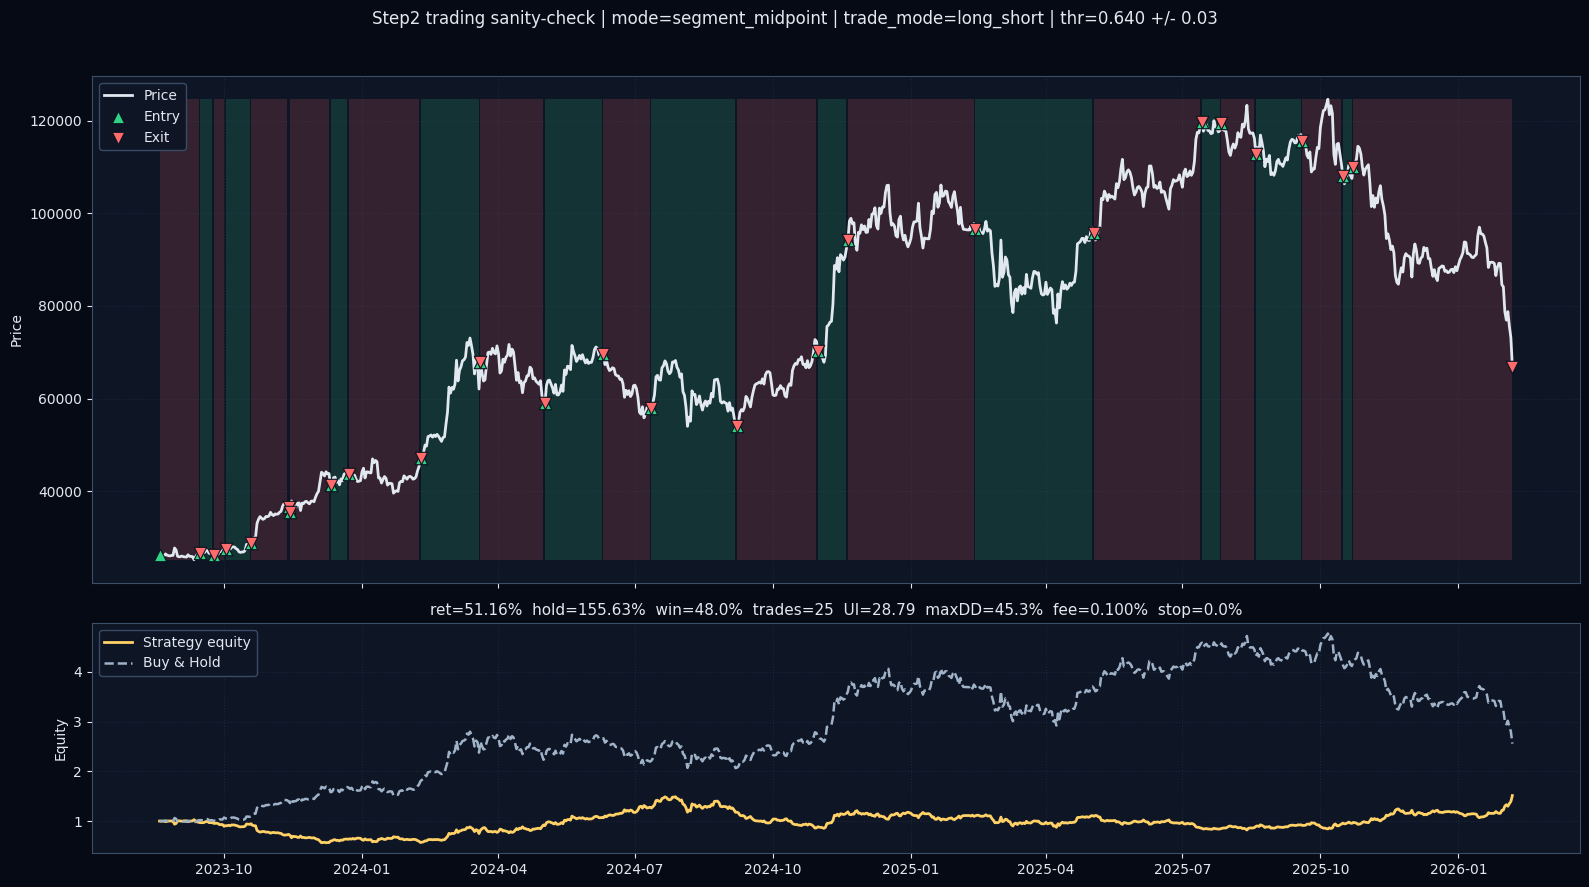

In [9]:
# ============================================================================
# Step 6) Trading sanity-check (after label visualization).
# ============================================================================
# Important: this is not a production trading engine.
# It is a transparent check on the same test window.

# ---------------------------------------------------------------------------
# How thresholds are converted into trading decisions
# ---------------------------------------------------------------------------
# best_t is selected on validation by classification objective.
# For trading we optionally create a neutral band around best_t:
#   threshold_up   = best_t + band
#   threshold_down = best_t - band
# Any probability between these boundaries is treated as "no-signal".
#
# Why min/max clipping:
# - Probability is bounded [0, 1], so we enforce safety margins [0.01, 0.99].
# - Prevents impossible threshold values when best_t is near edges.
threshold_up = min(0.99, float(best_t) + float(TRADING_NEUTRAL_BAND))
threshold_down = max(0.01, float(best_t) - float(TRADING_NEUTRAL_BAND))

# Build base signal with possible neutral state:
# -  1.0 => UP (long)
# -  0.0 => DOWN (flat in long_flat mode)
# -  NaN => neutral zone (no-signal)
signal_base = build_signal_from_proba(
    proba_up=p_test,
    threshold_up=threshold_up,
    threshold_down=threshold_down,
)

# ---------------------------------------------------------------------------
# Mode-specific signal mapping
# ---------------------------------------------------------------------------
# In long_short mode we intentionally use strict binary split at best_t:
# - P(UP) >= best_t -> +1 (long)
# - P(UP) <  best_t -> -1 (short)
# No neutral state here, because long_short backtest expects explicit side.
#
# In long_flat mode we keep signal_base as-is:
# - UP / DOWN / neutral (NaN) are all possible.
if TRADING_POSITION_MODE == 'long_short':
    signal_test = np.where(p_test >= float(best_t), 1.0, -1.0).astype(float)

    # For logging consistency we show effective thresholds used by this branch:
    # strict binary threshold means up==down==best_t.
    threshold_up = float(best_t)
    threshold_down = float(best_t)
else:
    signal_test = signal_base.astype(float)

# Initial signal distribution before fallback handling.
n_long = int(np.sum(signal_test == 1.0))
n_short = int(np.sum(signal_test == -1.0))
n_flat = int(np.sum(signal_test == 0.0))
n_neutral = int(np.sum(pd.isna(signal_test)))

# ---------------------------------------------------------------------------
# Optional anti-degeneracy fallback
# ---------------------------------------------------------------------------
# Purpose: avoid pathological runs where strategy has no actionable signals.
# - long_flat fallback: if there are zero long signals, force binary long/flat by best_t.
# - long_short fallback: if there are no non-zero signals, force binary long/short by best_t.
fallback_used = False
if TRADING_FORCE_BINARY_IF_NO_LONG:
    if TRADING_POSITION_MODE == 'long_flat' and n_long == 0:
        fallback_used = True
        signal_test = np.where(p_test >= float(best_t), 1.0, 0.0)
        threshold_up = float(best_t)
        threshold_down = float(best_t)
    elif TRADING_POSITION_MODE == 'long_short' and (n_long + n_short) == 0:
        fallback_used = True
        signal_test = np.where(p_test >= float(best_t), 1.0, -1.0)
        threshold_up = float(best_t)
        threshold_down = float(best_t)

    # Recompute counts after fallback.
    n_long = int(np.sum(signal_test == 1.0))
    n_short = int(np.sum(signal_test == -1.0))
    n_flat = int(np.sum(signal_test == 0.0))
    n_neutral = int(np.sum(pd.isna(signal_test)))

# Build explicit input frame for backtest.
# We keep probabilities and labels for later diagnostics/debug.
df_bt_input = test_df[['date', 'close']].copy().reset_index(drop=True)
df_bt_input['proba_up'] = p_test.astype(float)
df_bt_input['true_target'] = y_test.astype(np.int32)
df_bt_input['pred_target'] = y_pred_test.astype(np.int32)
df_bt_input['signal'] = signal_test

print('===== Trading Signal Setup =====')
print('trading_position_mode:', TRADING_POSITION_MODE)
print('p_test min/mean/max:', float(np.min(p_test)), float(np.mean(p_test)), float(np.max(p_test)))
print(f'threshold_down={threshold_down:.3f} | threshold_up={threshold_up:.3f} | neutral_band={TRADING_NEUTRAL_BAND:.3f}')
print('fallback_to_binary_used:', fallback_used)
print(f'signal counts -> long(1)={n_long}, short(-1)={n_short}, flat(0)={n_flat}, neutral(NaN)={n_neutral}')

# Run the backtest engine that corresponds to selected mode.
if TRADING_POSITION_MODE == 'long_short':
    run_bt = backtest_long_short_signals(
        df=df_bt_input,
        signal_col='signal',
        cfg=TRADING_CFG,
        date_col='date',
        price_col='close',
        verbose=False,
    )
else:
    run_bt = backtest_long_flat_signals(
        df=df_bt_input,
        signal_col='signal',
        cfg=TRADING_CFG,
        date_col='date',
        price_col='close',
        verbose=False,
    )

m_bt = dict(run_bt['metrics'])
print('===== Trading Backtest Metrics (Test only) =====')
print(
    f"return={m_bt.get('return_pct', float('nan')):.3%} | "
    f"hold_return={m_bt.get('hold_return_pct', float('nan')):.3%} | "
    f"excess={m_bt.get('excess_return_pct', float('nan')):.3%}"
)
print(
    f"max_drawdown={m_bt.get('max_drawdown_pct', float('nan')):.2f}% | "
    f"ulcer_index={m_bt.get('ulcer_index', float('nan')):.2f} | "
    f"trades={int(m_bt.get('num_trades', 0))} | "
    f"winrate={m_bt.get('winrate', float('nan')):.1%} | "
    f"exposure={m_bt.get('exposure_pct', float('nan')):.1f}%"
)
if 'exposure_short_pct' in m_bt:
    print(
        f"exposure_long={m_bt.get('exposure_long_pct', float('nan')):.1f}% | "
        f"exposure_short={m_bt.get('exposure_short_pct', float('nan')):.1f}%"
    )

display(run_bt['equity_df'][['date', 'close', 'signal', 'position', 'equity', 'hold_equity']].head(25))
if len(run_bt['trades']) > 0:
    display(run_bt['trades'].head(20))
else:
    print('No completed trades in this test window with current thresholds.')

plot_backtest_price_and_equity(
    run=run_bt,
    title=(
        f'Step2 trading sanity-check | mode={TARGET_MODE} | trade_mode={TRADING_POSITION_MODE} '
        f'| thr={best_t:.3f} +/- {TRADING_NEUTRAL_BAND:.2f}'
    ),
    vis_cfg=VisualizationConfig(),
)
